In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
import requests
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.stats import LombScargle

from emcee.autocorr import integrated_time

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import tensorflow as tf

In [4]:
import helpers
from jokerflow import kepler

In [5]:
def lomb_scargle_estimator(x, y, yerr=None,
                           min_period=None, max_period=None,
                           filter_period=None,
                           max_peaks=2,
                           **kwargs):
    """
    Estimate period of a time series using the periodogram
    Args:
        x (ndarray[N]): The times of the observations
        y (ndarray[N]): The observations at times ``x``
        yerr (Optional[ndarray[N]]): The uncertainties on ``y``
        min_period (Optional[float]): The minimum period to consider
        max_period (Optional[float]): The maximum period to consider
        filter_period (Optional[float]): If given, use a high-pass filter to
            down-weight period longer than this
        max_peaks (Optional[int]): The maximum number of peaks to return
            (default: 2)
    Returns:
        A dictionary with the computed ``periodogram`` and the parameters for
        up to ``max_peaks`` peaks in the periodogram.
    """
    if min_period is not None:
        kwargs["maximum_frequency"] = 1.0 / min_period
    if max_period is not None:
        kwargs["minimum_frequency"] = 1.0 / max_period

    # Estimate the power spectrum
    model = LombScargle(x, y, yerr)
    freq, power = model.autopower(method="fast", normalization="psd", **kwargs)
    power /= len(x)
    power_est = np.array(power)

    # Filter long periods
    if filter_period is not None:
        freq0 = 1.0 / filter_period
        filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
        power *= filt

    # Find and fit peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for i in peak_inds[:max_peaks]:
        A = np.vander(freq[i-1:i+2], 3)
        w = np.linalg.solve(A, np.log(power[i-1:i+2]))
        sigma2 = -0.5 / w[0]
        freq0 = w[1] * sigma2
        peaks.append(dict(
            log_power=w[2] + 0.5*freq0**2 / sigma2,
            period=1.0 / freq0,
            period_uncert=np.sqrt(sigma2 / freq0**4),
        ))

    return dict(
        periodogram=(freq, power_est),
        peaks=peaks,
    )

In [17]:
def get_dataset(args):
    ind, url = args
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    return np.array([l.split() + [ind] for l in r.text.splitlines()
                     if not l.startswith("\\") and not l.startswith("|")],
                    dtype=float)

urls = [
    "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0074/0074995/data/UID_0074995_RVC_002.tbl",
#     "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0074/0074995/data/UID_0074995_RVC_003.tbl",
#     "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0074/0074995/data/UID_0074995_RVC_001.tbl",
]
data = np.concatenate(list(map(get_dataset, enumerate(urls))), axis=0)
inds = np.argsort(data[:, 0])
data = np.array(data[inds])

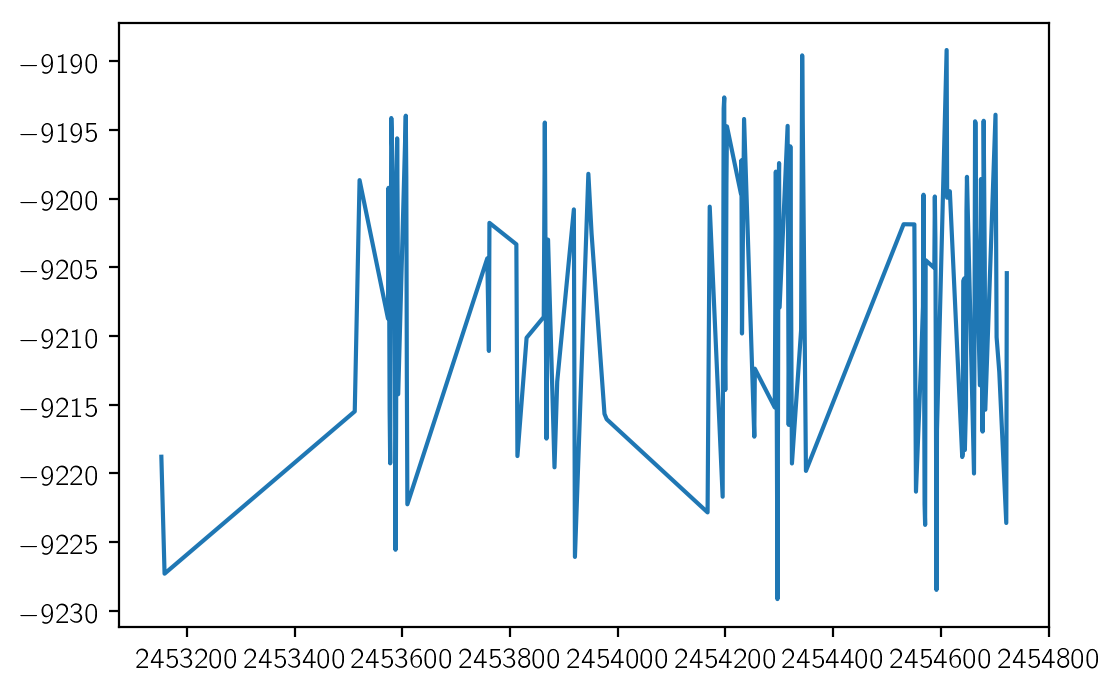

In [59]:
plt.plot(data[:, 0], data[:, 1])

In [20]:
t = np.array(data[:, 0])
y = np.array(data[:, 1])
yerr = np.array(data[:, 2])

ref_time = np.mean(t)
ref_vel = np.mean(y)

t -= ref_time
y -= ref_vel

In [46]:
min_period = np.median(np.diff(np.sort(t)))
max_period = 0.5*(t.max() - t.min())
min_amp = 2*np.median(yerr)
max_amp = y.max() - y.min()

In [47]:
min_period

1.904229000210762

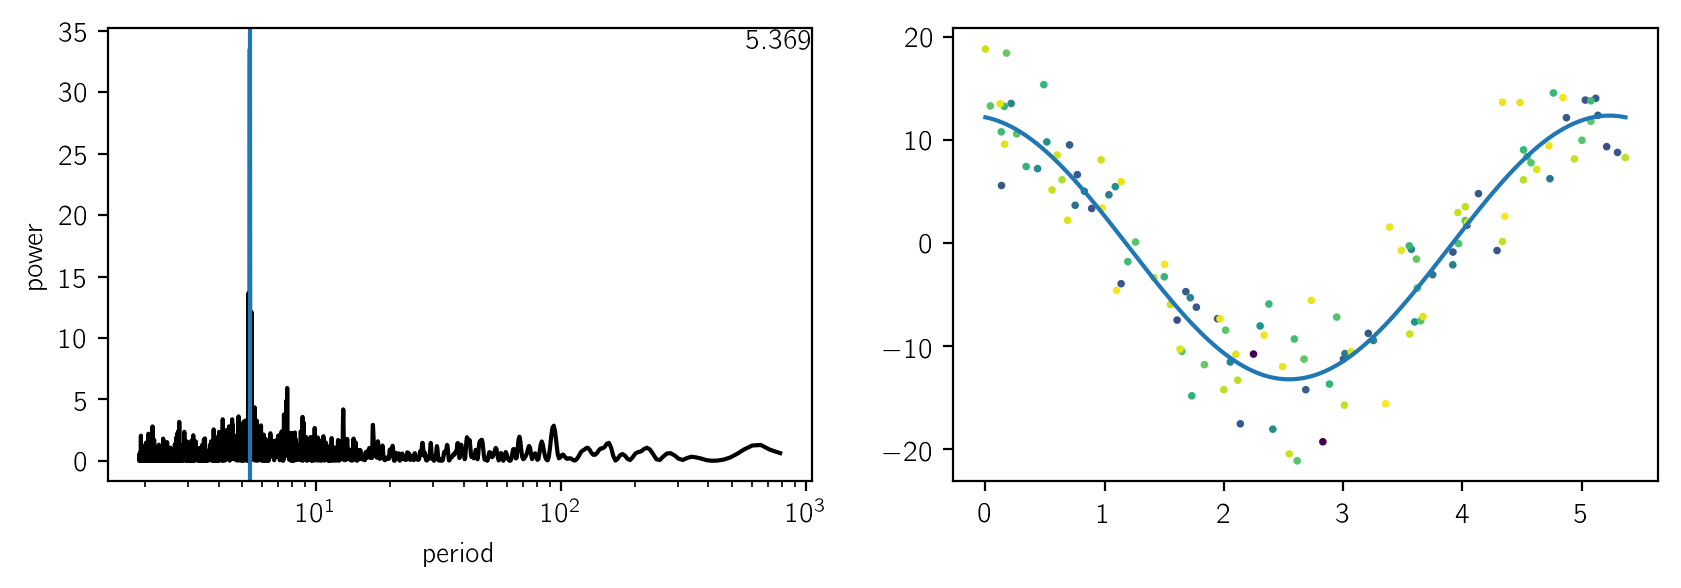

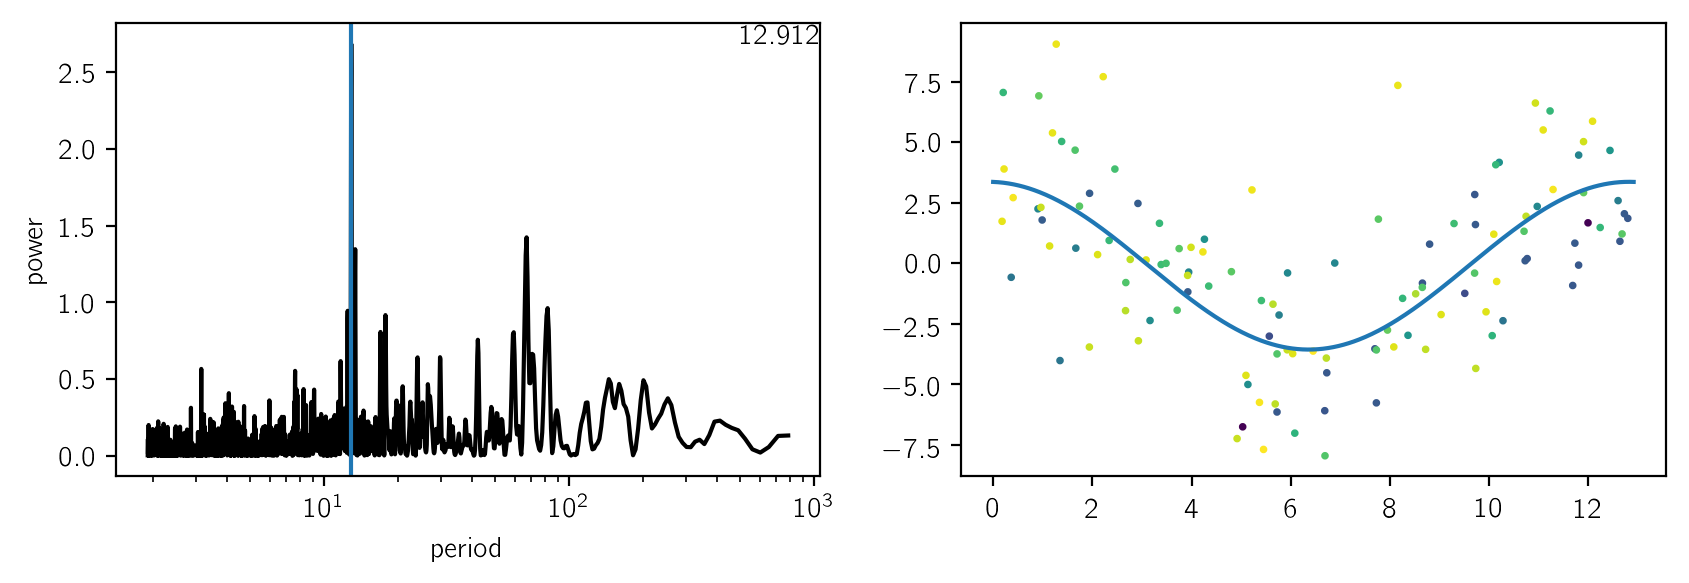

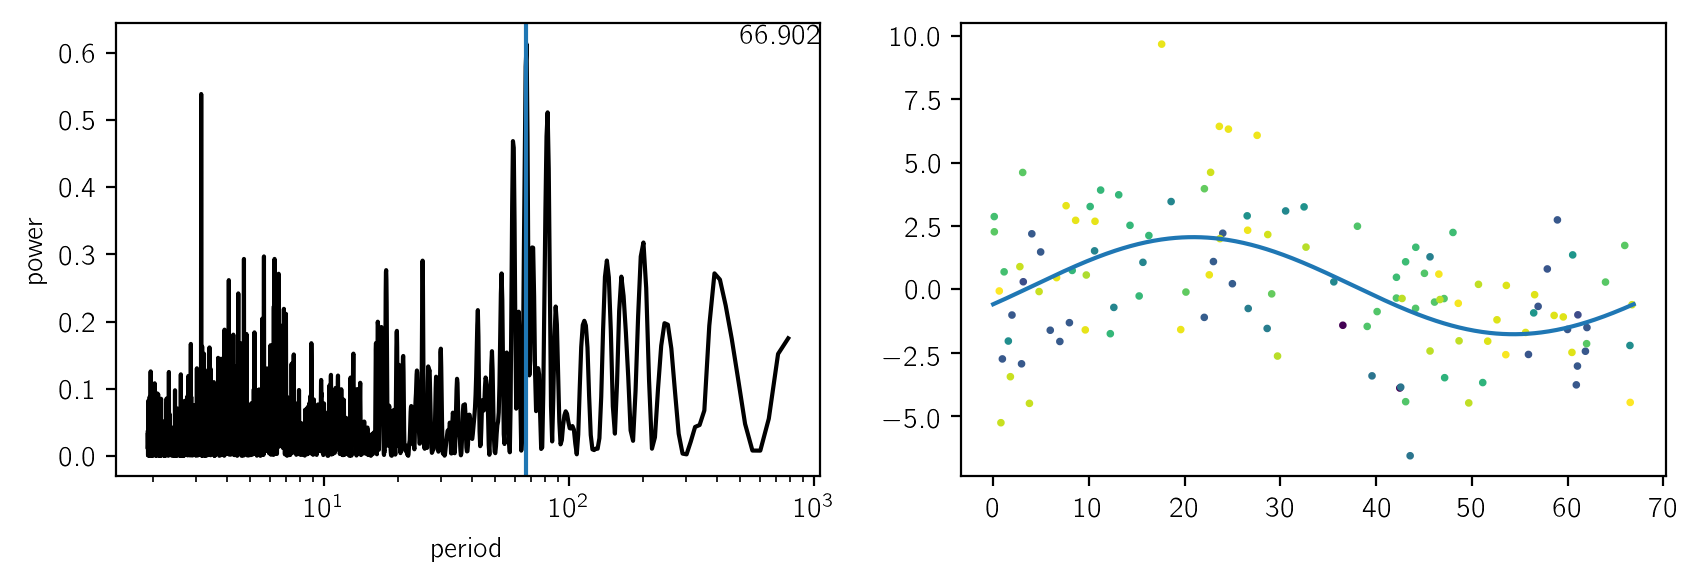

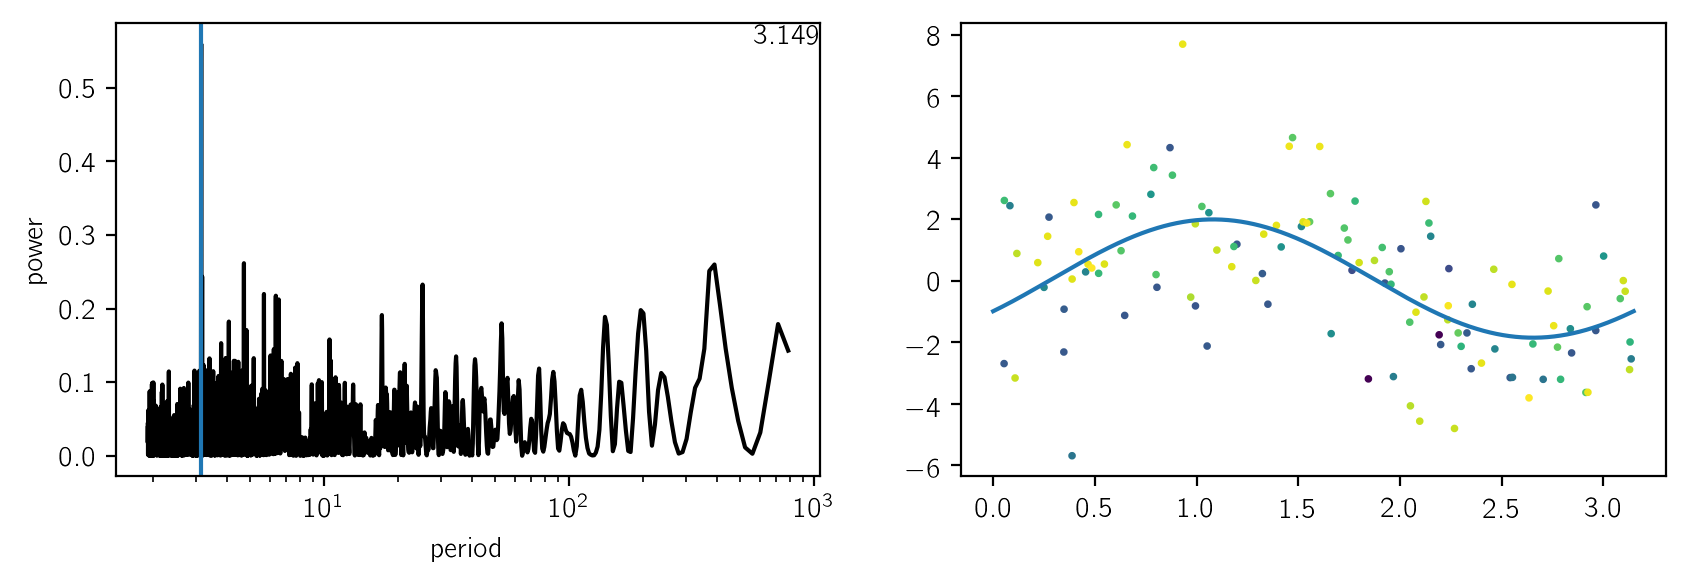

In [51]:
y0 = np.array(y)
peaks = []
for i in range(4):
    m = lomb_scargle_estimator(t, y0, yerr, max_period=max_period, min_period=min_period, max_peaks=1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.semilogx(1.0/m["periodogram"][0], m["periodogram"][1], "k")

    for peak in m["peaks"]:
        ax1.axvline(peak["period"])
    ax1.set_xlabel("period")
    ax1.set_ylabel("power")

    peak = dict(m["peaks"][0])
    A = np.vstack([
        np.sin(2*np.pi*t/peak["period"]),
        np.cos(2*np.pi*t/peak["period"]),
        np.ones_like(t),
    ]).T
    w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, y0))
    x = np.linspace(0, peak["period"], 500)
    Am = np.vstack([
        np.sin(2*np.pi*x/peak["period"]),
        np.cos(2*np.pi*x/peak["period"]),
        np.ones_like(x),
    ]).T
    model = np.dot(Am, w)
    peak["amp"] = 0.5*(model.max() - model.min())
    peak["phase"] = np.arctan2(w[1], w[0])

    ax2.scatter(t % peak["period"], y0, c=t, s=3)
#     ax2.scatter(t % peak["period"], y, c=t)
    ax2.plot(x, model)

    ax1.annotate("{0:.3f}".format(peak["period"]), xy=(1, 1),
                 xycoords="axes fraction", ha="right", va="top")
    
    y0 -= np.dot(A, w)
    
    peaks.append(peak)

In [52]:
peaks

[{'amp': 12.796271406682521,
  'log_power': 3.5120009781676345,
  'period': 5.368671225811358,
  'period_uncert': 0.007215688719733388,
  'phase': 1.7305016914377458},
 {'amp': 3.464160717308282,
  'log_power': 0.9897817493474577,
  'period': 12.91230943668496,
  'period_uncert': 0.04834044926634565,
  'phase': 1.617124464075706},
 {'amp': 1.9141127035292544,
  'log_power': -0.47292791741847395,
  'period': 66.9019079802384,
  'period_uncert': 1.022276213641119,
  'phase': -0.3924012142128336},
 {'amp': 1.9251859622252834,
  'log_power': -0.5723786958260462,
  'period': 3.1492334577530556,
  'period_uncert': 0.002840820892453523,
  'phase': -0.5850569242437378}]

In [53]:
session = tf.InteractiveSession()

In [54]:
# These functions are used to transform bounded parameters to parameters to parameters with infinite range
def get_param_for_value(value, min_value, max_value):
    if np.any(value <= min_value) or np.any(value >= max_value):
        raise ValueError("value must be in the range (min_value, max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_param(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, dtype=tf.float64):
    param = tf.Variable(get_param_for_value(value, min_value, max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = tf.log(var - min_value) + tf.log(max_value - var) - np.log(max_value - min_value)
    return param, var, tf.reduce_sum(log_jacobian), (min_value, max_value)

# This function constrains a pair of parameters to be a unit vector
def get_unit_vector(name, x_value, y_value, dtype=tf.float64):
    x_param = tf.Variable(x_value, dtype=dtype, name=name + "_x_param")
    y_param = tf.Variable(y_value, dtype=dtype, name=name + "_y_param")
    norm = tf.square(x_param) + tf.square(y_param)
    log_jacobian = -0.5*tf.reduce_sum(norm)
    norm = tf.sqrt(norm)
    x = x_param / norm
    y = y_param / norm
    return x_param, y_param, x, y, log_jacobian

In [163]:
np.random.seed(1234)
T = tf.float64

# Simulate some timestamps
# t = np.sort(np.random.uniform(0, 365.0, 25))
t_tensor = tf.placeholder(T, name="t")
feed_dict = {t_tensor: t}

# We will accumulate the log_prior as we go because we'll need to include the
# log Jacobians introduced by the reparameterizations
log_prior = tf.constant(0.0, dtype=T)

# The semi-amplitudes and periods
n_planets = len(peaks)
log_K_param, log_K, log_jac, log_K_range = get_bounded_variable(
    "log_K", np.log([np.clip(p["amp"], min_amp+1e-5, max_amp-1e-5) for p in peaks[:n_planets]]), np.log(min_amp), np.log(max_amp), dtype=T)
log_prior += log_jac
log_P_param, log_P, log_jac, log_P_range = get_bounded_variable(
    "log_period", np.log([p["period"] for p in peaks[:n_planets]]), np.log(min_period), np.log(max_period), dtype=T)
log_prior += log_jac

# Here I'm using a transformation to constrain the omega vector [cos(omega), sin(omega)]
# to be a unit vector. I got this from the Stan manual. We sample in 'w_x' and 'w_y' and
# we will get a uniform distribution over omega.
cw, sw = np.ones(n_planets), np.zeros(n_planets) # np.random.randn(2, n_planets)
w_x, w_y, cosw, sinw, log_jac = get_unit_vector("omega", cw, sw, dtype=T)
log_prior += log_jac

# Eccentricity should be constrained to be between 0 and 1.
e_param, e, log_jac, e_range = get_bounded_variable("e", np.random.uniform(0, 0.01, n_planets), 0.0, 1.0, dtype=T)
log_prior += log_jac

# phi is the orbital phase. Like omega above, we'll sample in the unit vector [cos(phi), sin(phi)]
phi = np.array([p["phase"] for p in peaks[:n_planets]]) % (2 * np.pi) - 0.5*np.pi
phi_param, phi, log_jac, phi_range = get_bounded_variable("phi", phi, 0, 2*np.pi, dtype=T)
log_prior += log_jac
# phi_x, phi_y, cosphi, sinphi, log_jac = get_unit_vector("phi", np.cos(phi), np.sin(phi), dtype=T)
# log_prior += log_jac
# phi = tf.atan2(sinphi, cosphi)

# Parameters for the RV zero-point and jitter
rv0 = tf.Variable(0.0, dtype=T)
log_jitter = tf.Variable(np.log(1.0), dtype=T)

# This is the list of parameters that we will fit for
var_list = [log_K_param, log_P_param, w_x, w_y, e_param, phi_param, rv0, log_jitter]

# Here is an implementation of the RV model
n = 2*np.pi*tf.exp(-log_P)
K = tf.exp(log_K)
w = tf.atan2(sinw, cosw)
jitter2 = tf.exp(2*log_jitter)
t0 = (phi + w) / n

# Solve Kepler's equation and compute the RV signal for each planet
M = n * t_tensor[:, None] - (phi + w)
E = kepler(M, e + tf.zeros_like(M))
f = 2*tf.atan2(tf.sqrt(1+e)*tf.tan(0.5*E), tf.sqrt(1-e)+tf.zeros_like(E))
rv_models = K * (cosw*(tf.cos(f)+e) - sinw*tf.sin(f))

# Sum the contributions from each planet
rv_model = rv0 + tf.reduce_sum(rv_models, axis=1)

# Compute the likelihood
yerr2 = yerr**2
log_like = -0.5 * tf.reduce_sum(
    tf.square(y - rv_model) / (yerr2 + jitter2) + tf.log(yerr2 + jitter2)
)
log_prob = log_prior + log_like

session.run(tf.global_variables_initializer())

In [164]:
neg_log_prob = -log_prob

for i in range(10):
    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[phi_param])
    opt.minimize(session, feed_dict=feed_dict)

    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_K_param])
    opt.minimize(session, feed_dict=feed_dict)

    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[e_param, w_x, w_y])
    opt.minimize(session, feed_dict=feed_dict)

    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_P_param])
    opt.minimize(session, feed_dict=feed_dict)

    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=var_list)
    opt.minimize(session, feed_dict=feed_dict)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 260.735757
  Number of iterations: 24
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 242.352121
  Number of iterations: 32
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 206.616728
  Number of iterations: 77
  Number of functions evaluations: 135
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 205.886759
  Number of iterations: 16
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 172.318367
  N

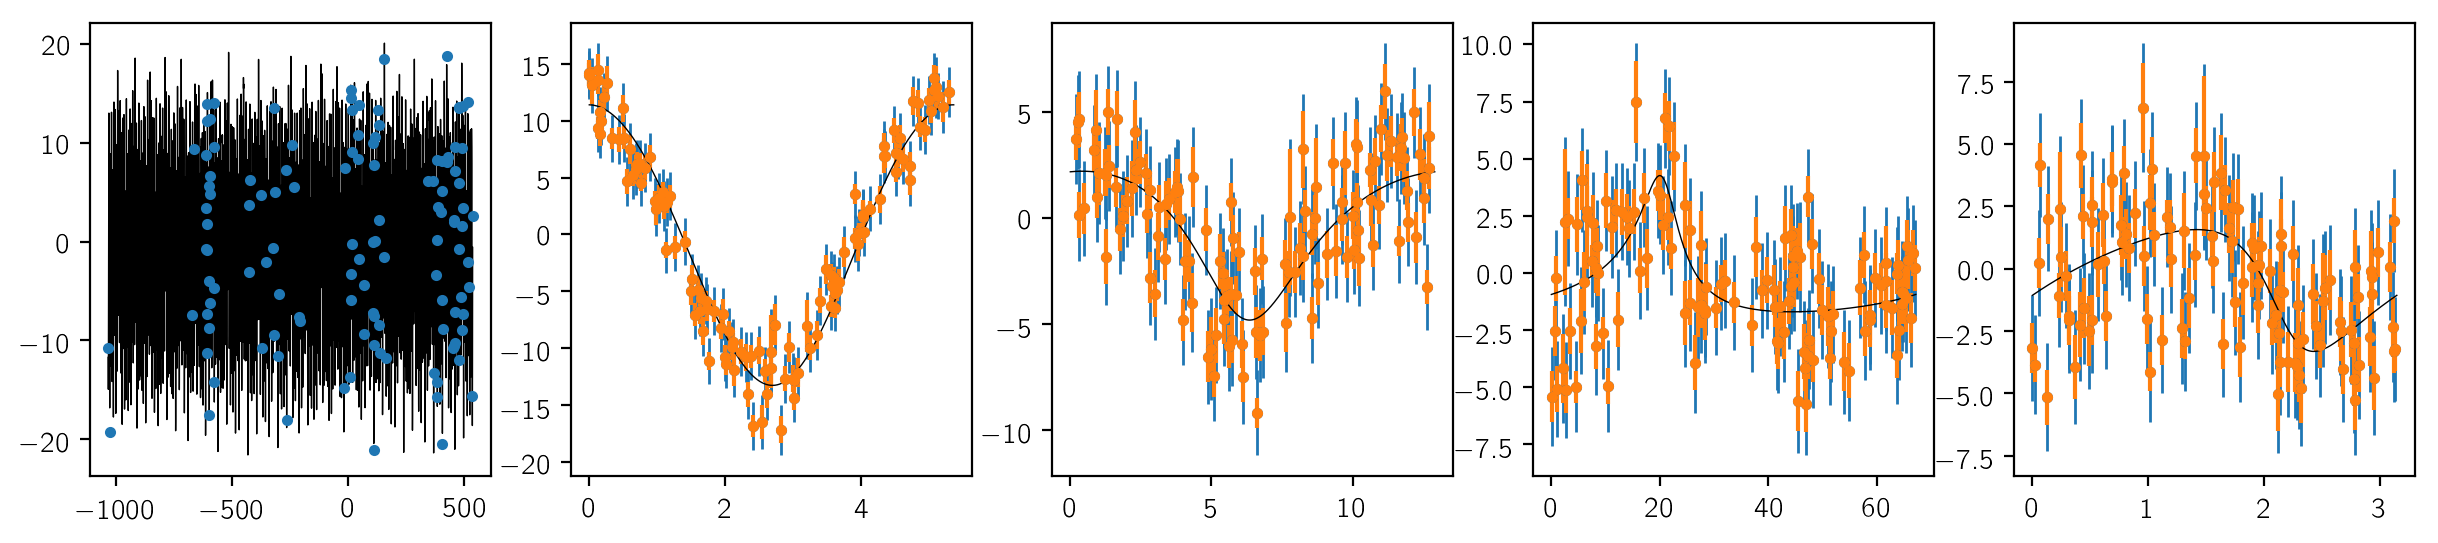

In [165]:
model = helpers.TFModel(log_prob, var_list, feed_dict=feed_dict)
model.setup(session)

sample = model.current_vector()
fd0 = model.vector_to_feed_dict(sample)

inds = np.random.randint(len(chain), size=100)
fig, axes = plt.subplots(1, 1 + n_planets, figsize=(15, 3))

ax = axes[0]
x = np.arange(t.min(), t.max(), 0.1)
fd = dict(fd0)
fd[t_tensor] = x
m = session.run(rv_model, feed_dict=fd)
ax.plot(x, m, "k", lw=0.5)
ax.plot(t, y, ".")

zero, models, periods, err = session.run([rv0, rv_models, tf.exp(log_P), tf.sqrt(yerr2+jitter2)], feed_dict=fd0)
for n in range(n_planets):
    ax = axes[n+1]
    x = np.linspace(0, periods[n], 1000)
    t0_value = session.run(t0, feed_dict=fd)
    fd[t_tensor] = x
    m = session.run(rv_models, feed_dict=fd)
    ax.plot(x, zero + m[:, n], "k", lw=0.5)

    mask = np.arange(n_planets) != n
    ax.errorbar(t%periods[n], y - np.sum(models[:, mask], axis=1), fmt=".", yerr=err, lw=1)
    ax.errorbar(t%periods[n], y - np.sum(models[:, mask], axis=1), fmt=".", yerr=yerr)

In [166]:
session.run(log_prob, feed_dict=feed_dict)

-172.1890746444609

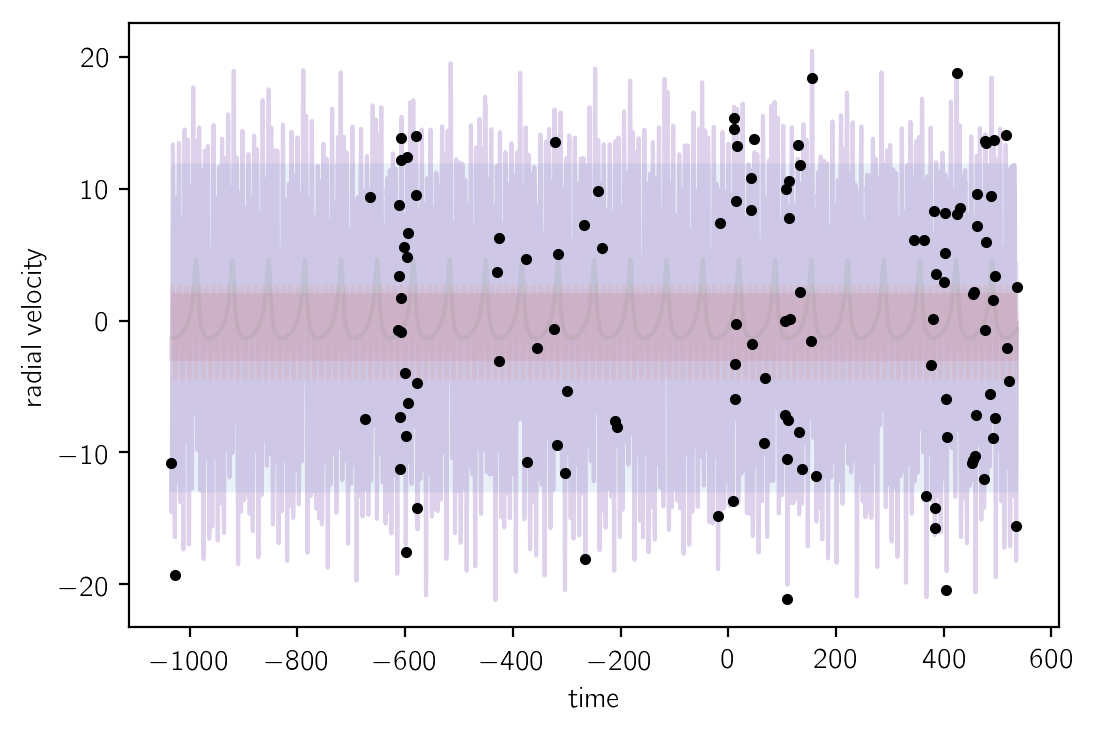

In [167]:
x = np.arange(t.min(), t.max(), 0.1)
fd = {t_tensor: x}
mod = session.run(rv_models, feed_dict=fd)
plt.plot(x, mod, alpha=0.1)
plt.plot(x, np.sum(mod, axis=1), alpha=0.3)
plt.plot(t, y, ".k")
plt.xlabel("time")
plt.ylabel("radial velocity");

In [168]:
# We'll use the inverse Hessian to estimate the initial scales of the problem
hess = session.run(tf.hessians(log_prob, var_list), feed_dict=feed_dict)
var = 1.0 / np.abs(np.concatenate([np.diag(np.atleast_2d(h)) for h in hess]))

In [169]:
# Here we run a burn-in where we tune the step size
metric = helpers.DenseMetric(np.diag(var))
nuts = helpers.tf_simple_nuts(
    session,
    log_prob,
    var_list,
    20000,                          # The number of MCMC steps
    helpers.StepSizeEstimator(),       # The integration step size
    metric=metric,                 # The scaling metric computed above
    feed_dict=feed_dict,
    tune=True,
)

5.4e-03, 0.471:   1%|          | 130/20000 [00:09<19:36, 16.89it/s]

125 updating metric
1.0 1.0


1.4e-02, 0.465:   1%|          | 156/20000 [00:10<12:31, 26.39it/s]

150 updating metric
1.0 1.0


5.7e-03, 0.464:   1%|          | 207/20000 [00:12<15:55, 20.71it/s]

200 updating metric
1.0 1.0


5.4e-03, 0.466:   2%|▏         | 305/20000 [00:17<13:52, 23.65it/s]

300 updating metric
1.0 1.0


1.8e-02, 0.474:   3%|▎         | 506/20000 [00:28<15:28, 21.00it/s]

500 updating metric
1.0 1.0


8.0e-02, 0.481:   5%|▍         | 906/20000 [00:50<17:07, 18.58it/s]

900 updating metric
1.0 1.0


7.2e-02, 0.487:   9%|▊         | 1705/20000 [01:39<15:40, 19.45it/s]

1700 updating metric
1.0 1.0


7.2e-02, 0.491:  17%|█▋        | 3305/20000 [03:23<17:53, 15.55it/s]

3300 updating metric
1.0 1.0


8.8e-02, 0.496:  50%|████▉     | 9905/20000 [11:29<10:35, 15.87it/s]

9900 updating metric
1.0 1.0


9.7e-02, 0.548: 100%|██████████| 20000/20000 [23:50<00:00, 13.85it/s]


In [170]:
chain = np.array(nuts[0][10000:])
lp_chain = np.array(nuts[1][10000:])

In [171]:
tau_nuts = integrated_time(chain[:, None, :])
neff_nuts = len(chain) / np.mean(tau_nuts)
tau_nuts, neff_nuts

(array([  2.78994128,  10.0409913 , 123.53485966,  58.86654706,
          1.49746677,  13.3930337 ,  15.75953784,   4.9366692 ,
        146.89012997,  52.54471314,  51.49926402,  41.07906607,
        154.44290553, 165.55590544,  29.56882568, 123.23083557,
         55.92407254,  96.18871042, 143.72627019,  56.51056186,
         83.44319492,  84.19174172,  29.49112931,   6.1563202 ,
         19.74475593,   3.19973111]), 165.16250416800418)

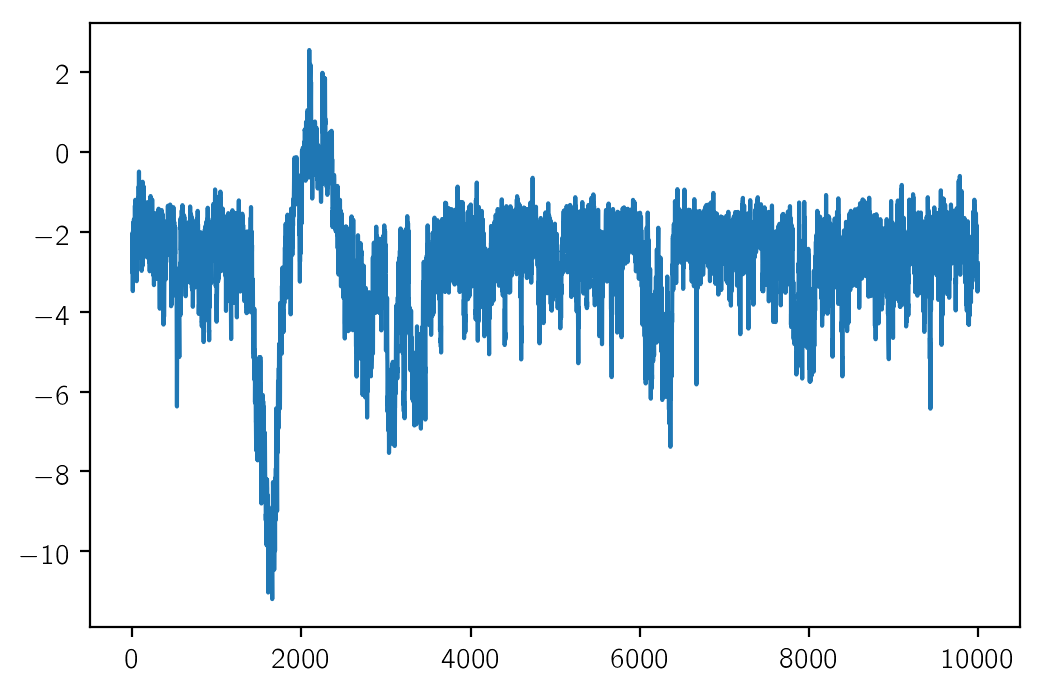

In [182]:
plt.plot(chain[:, 2]);

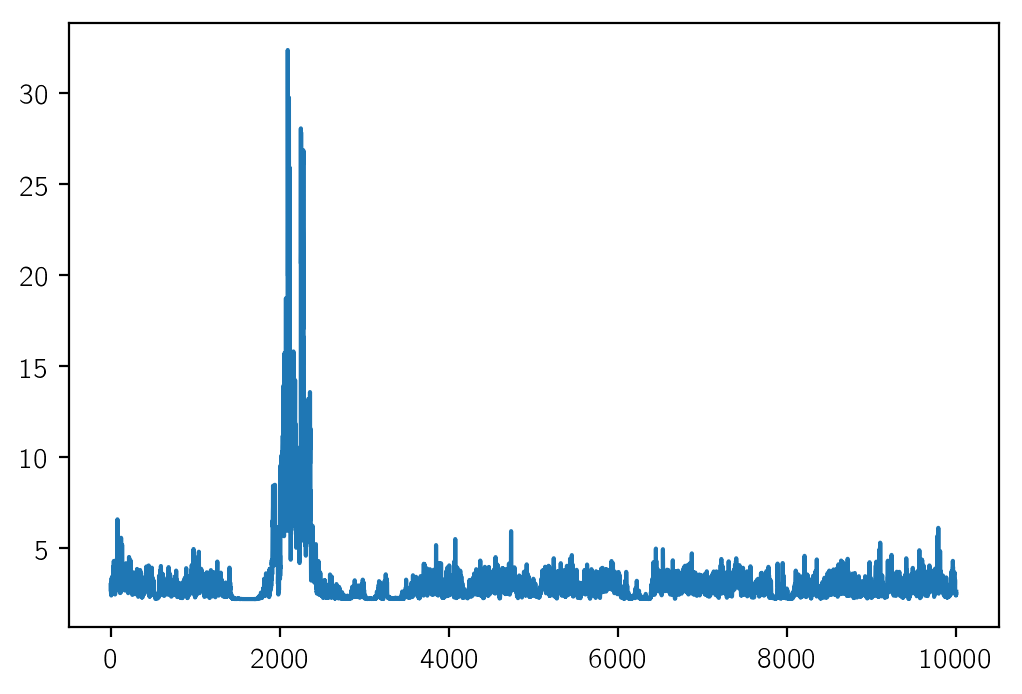

In [183]:
plt.plot(np.exp(get_value_for_param(chain[:, 2], *log_K_range)));

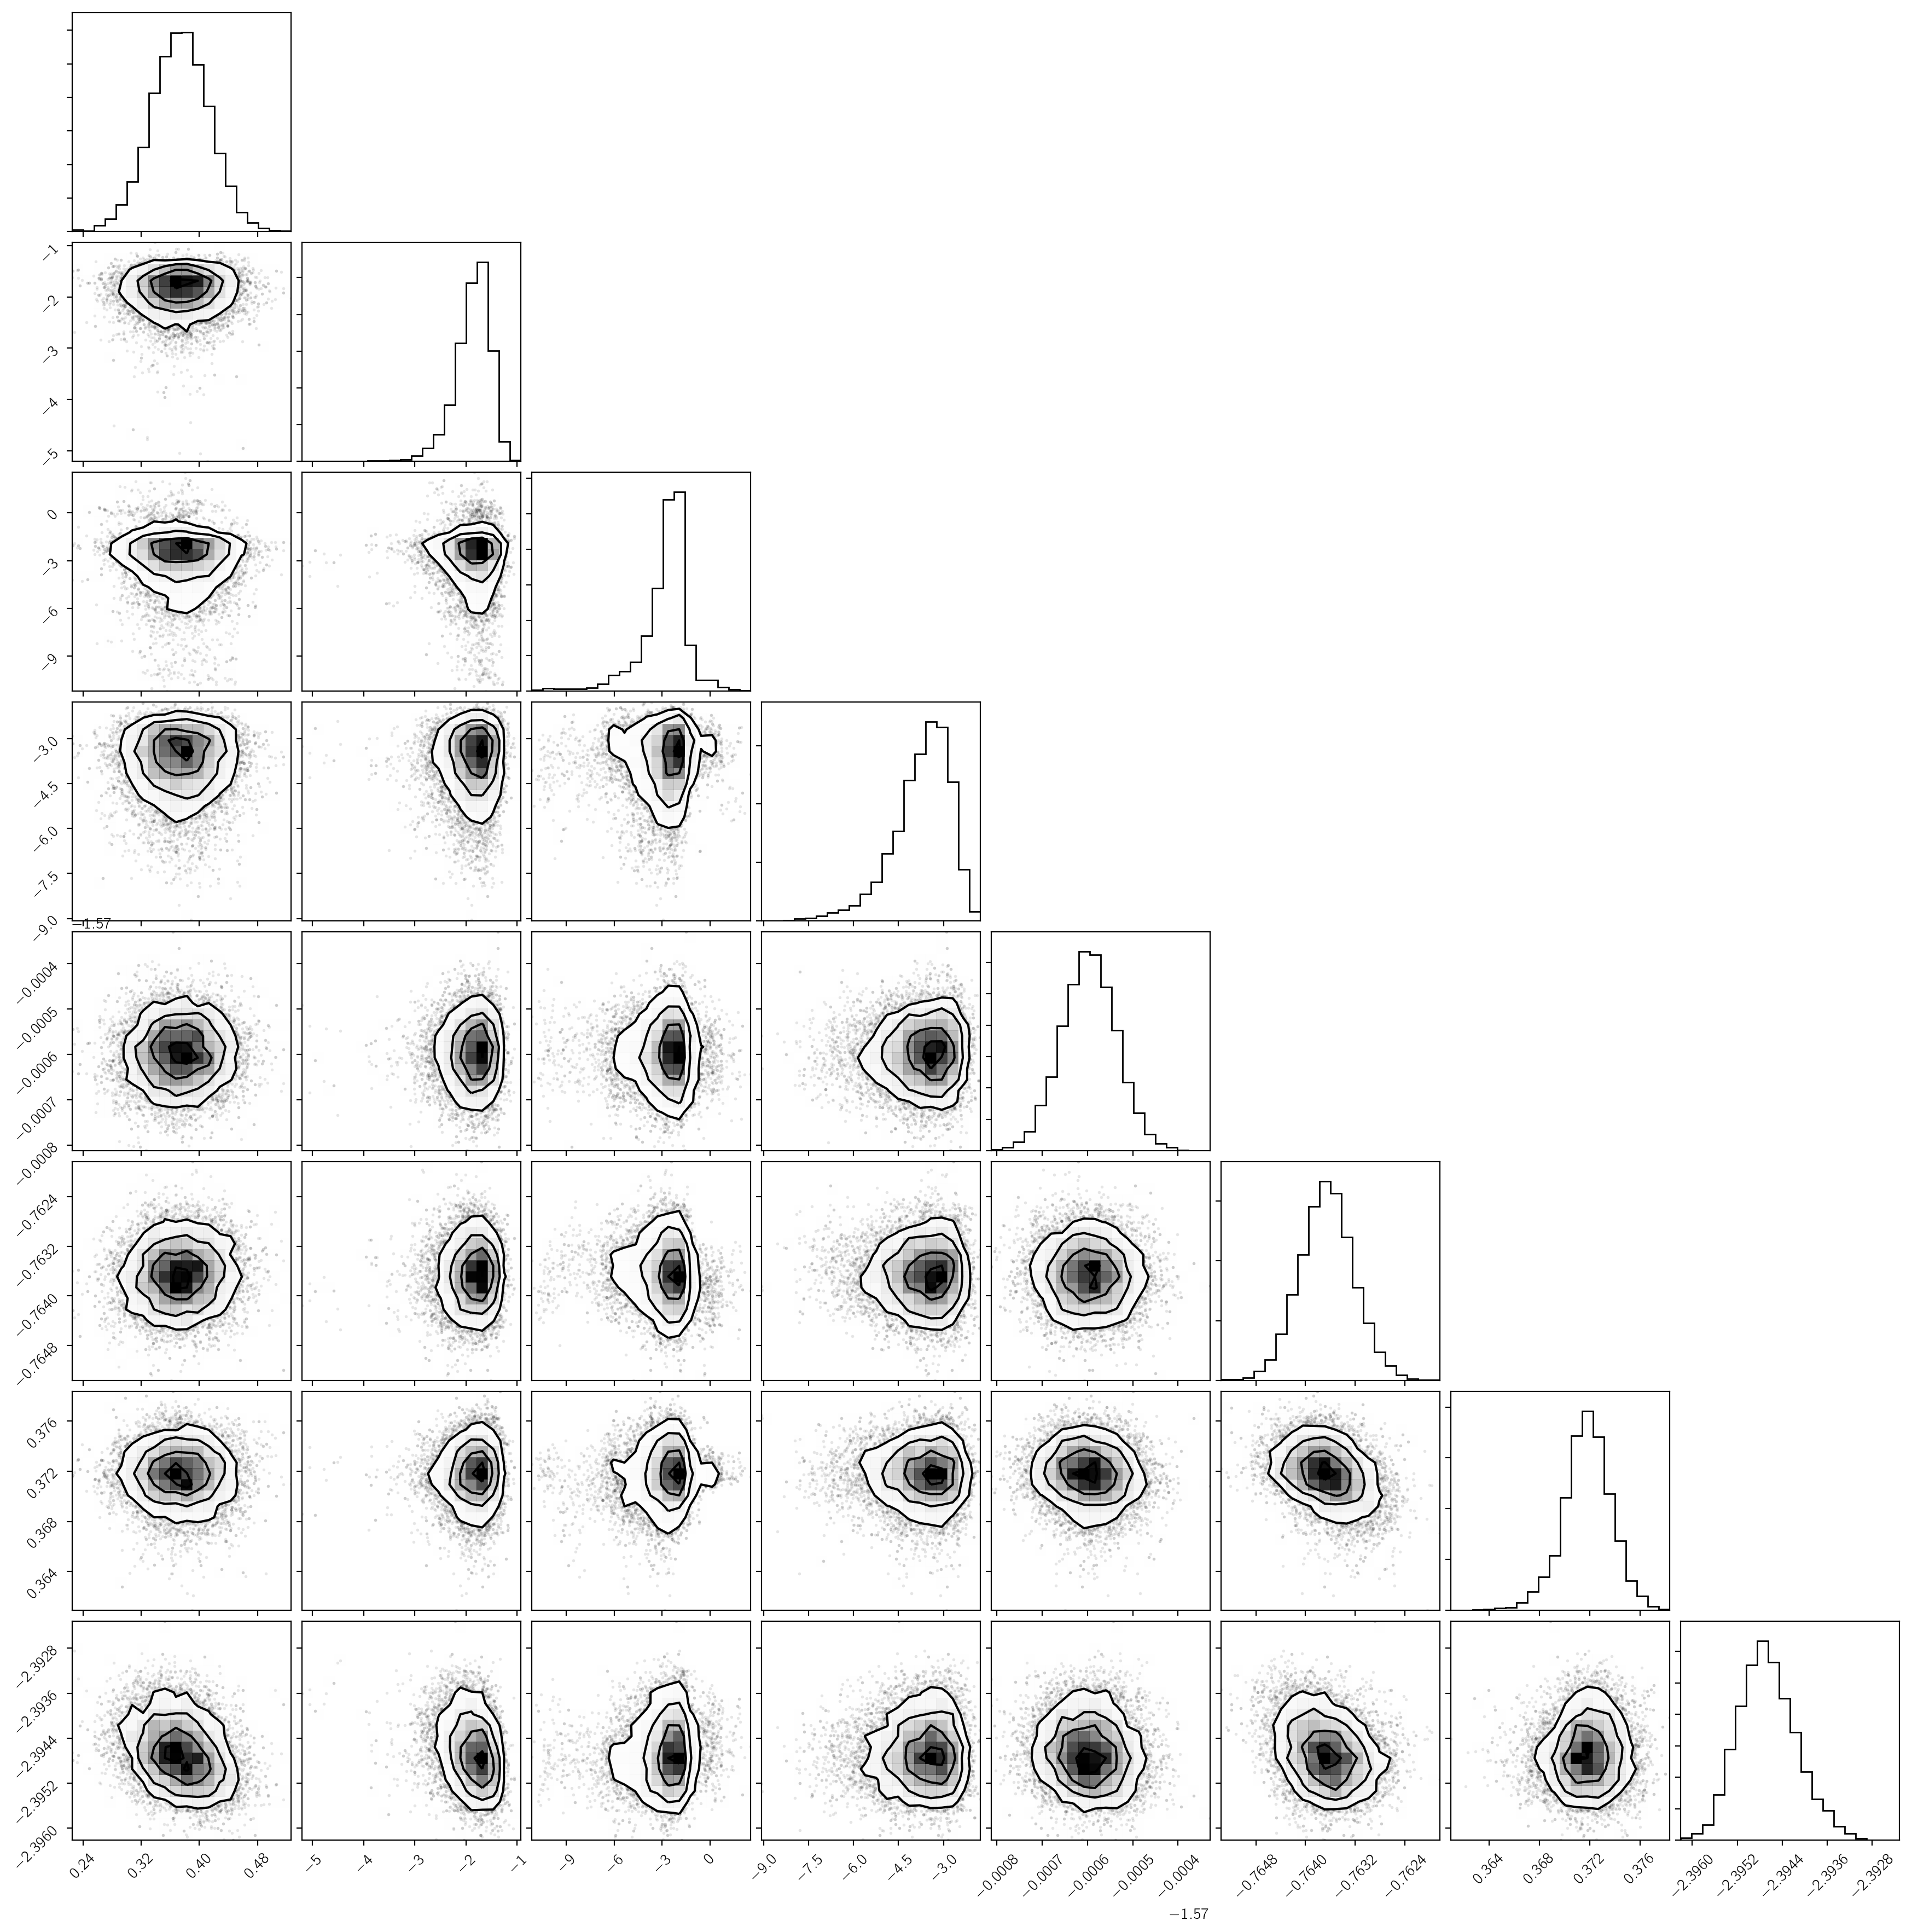

In [174]:
corner.corner(chain[:, :2*n_planets]);

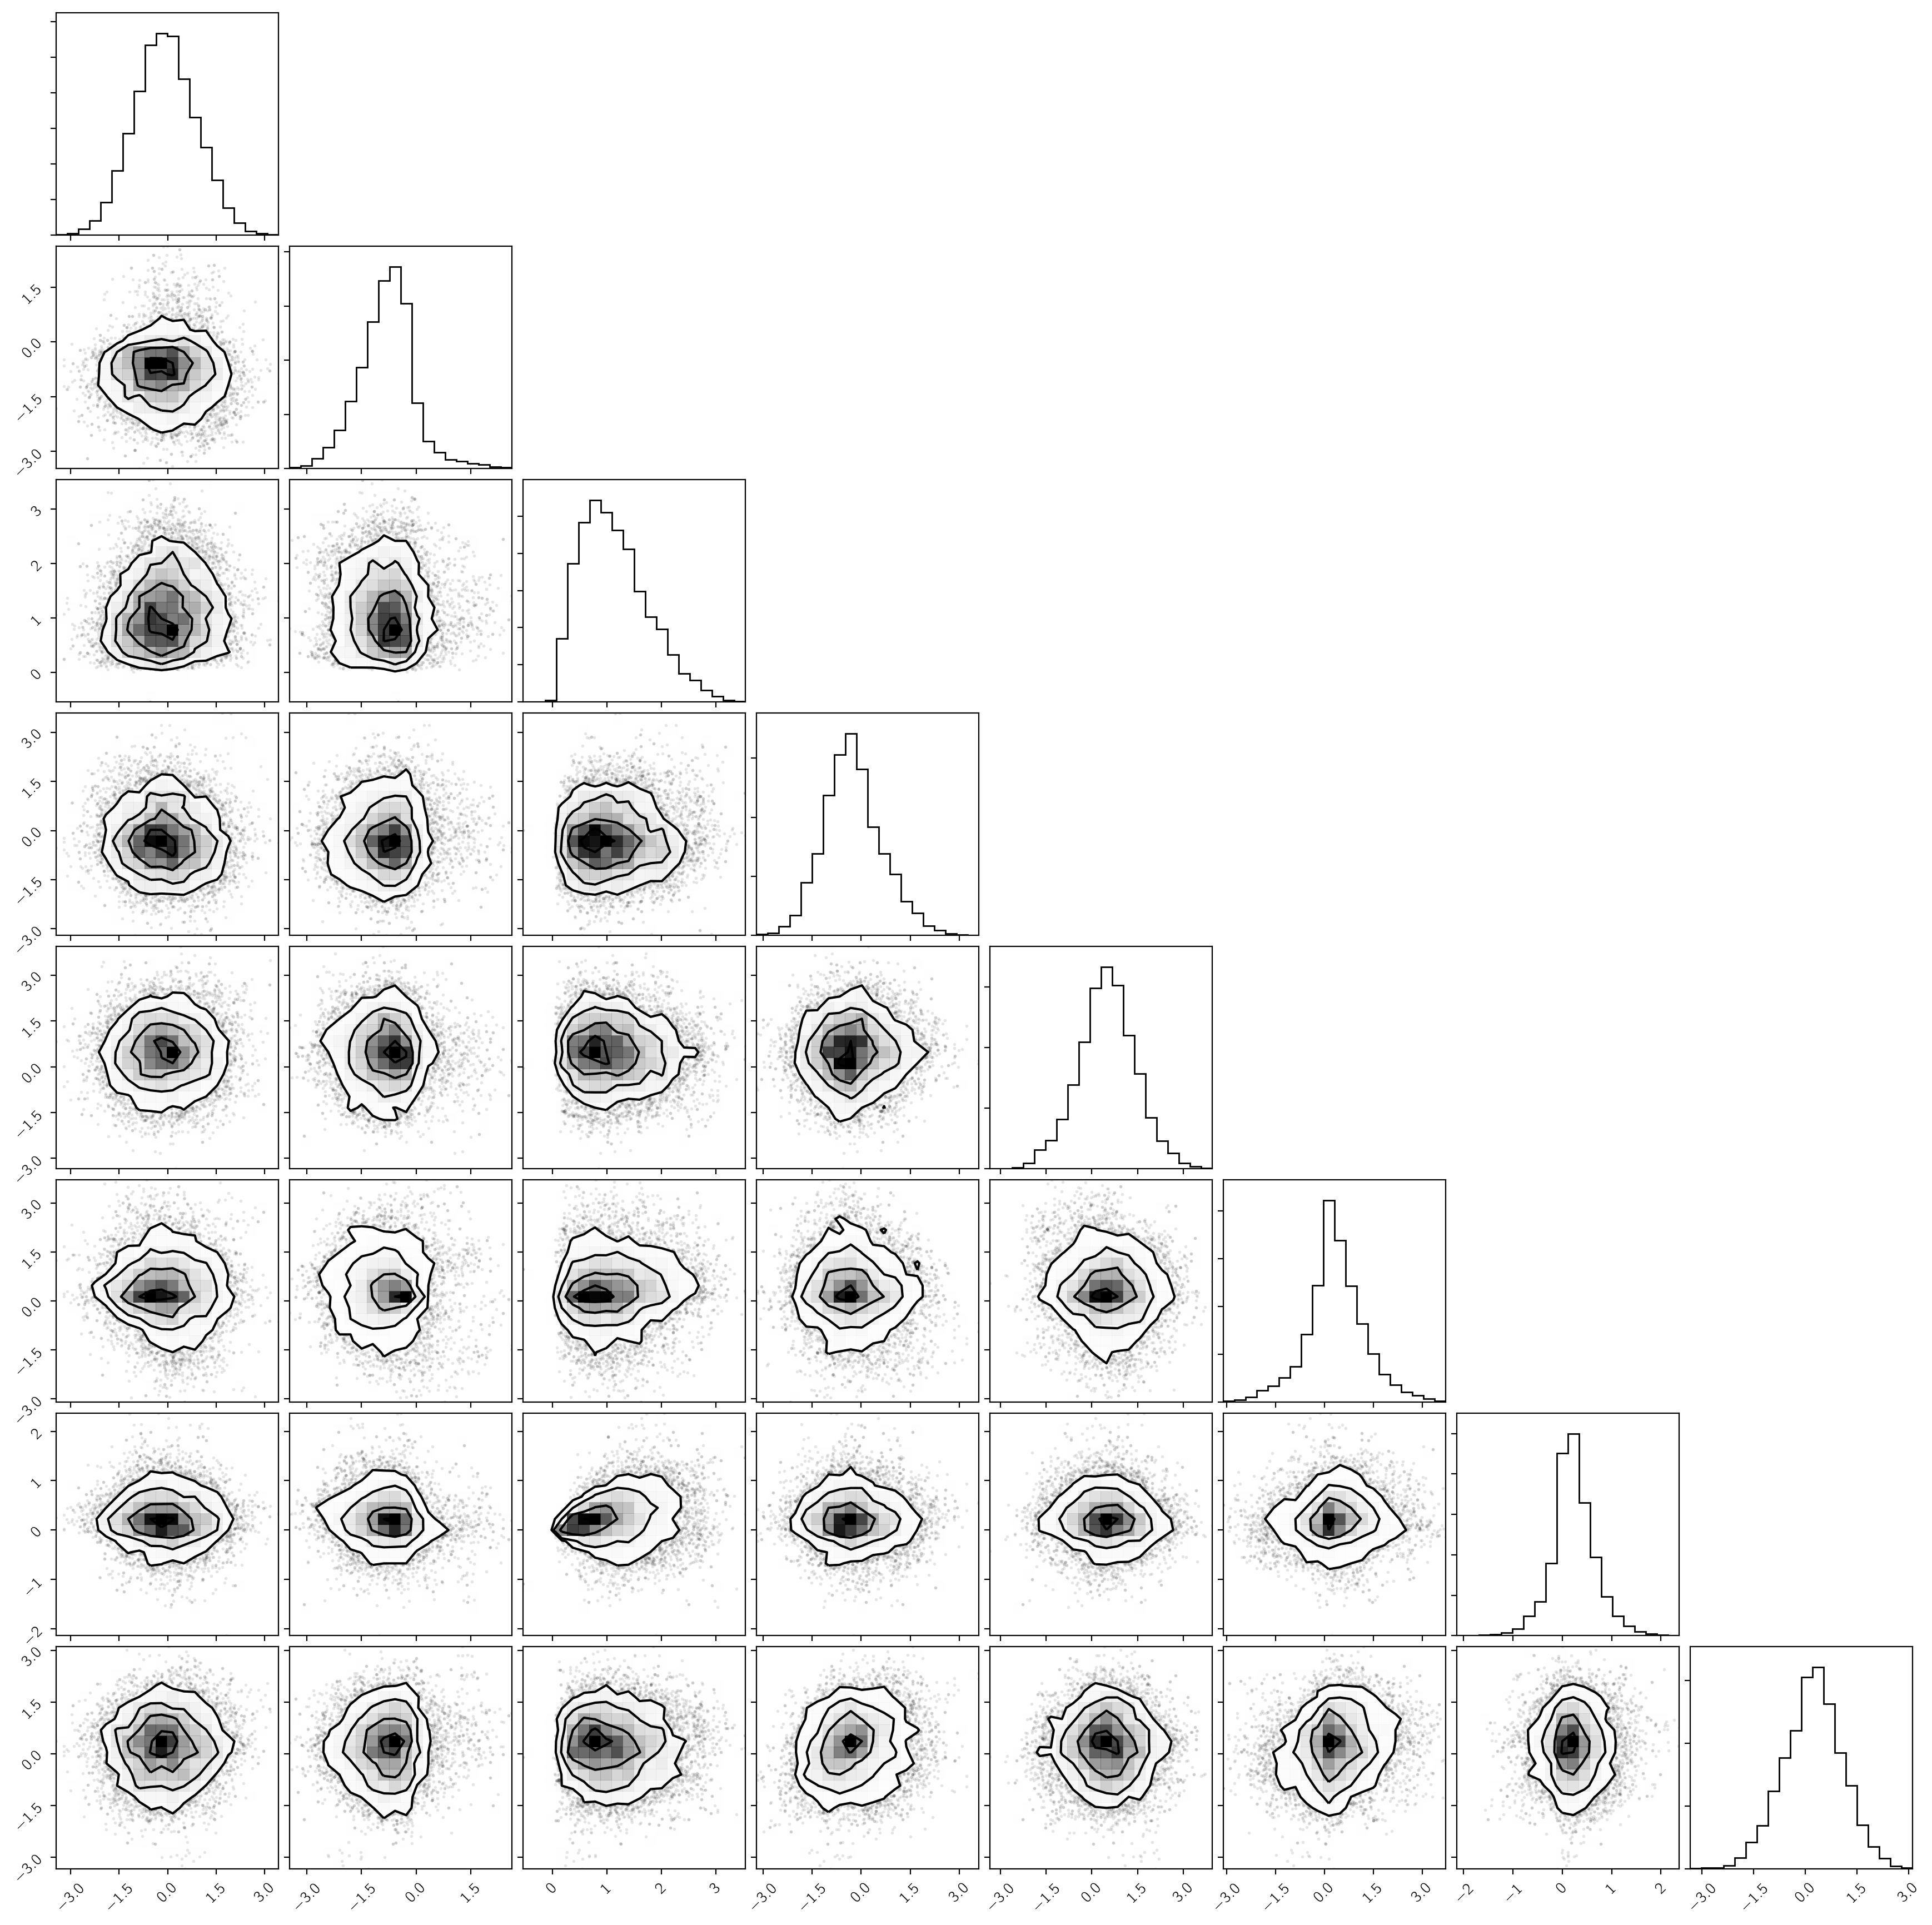

In [175]:
corner.corner(chain[:, 2*n_planets:4*n_planets]);

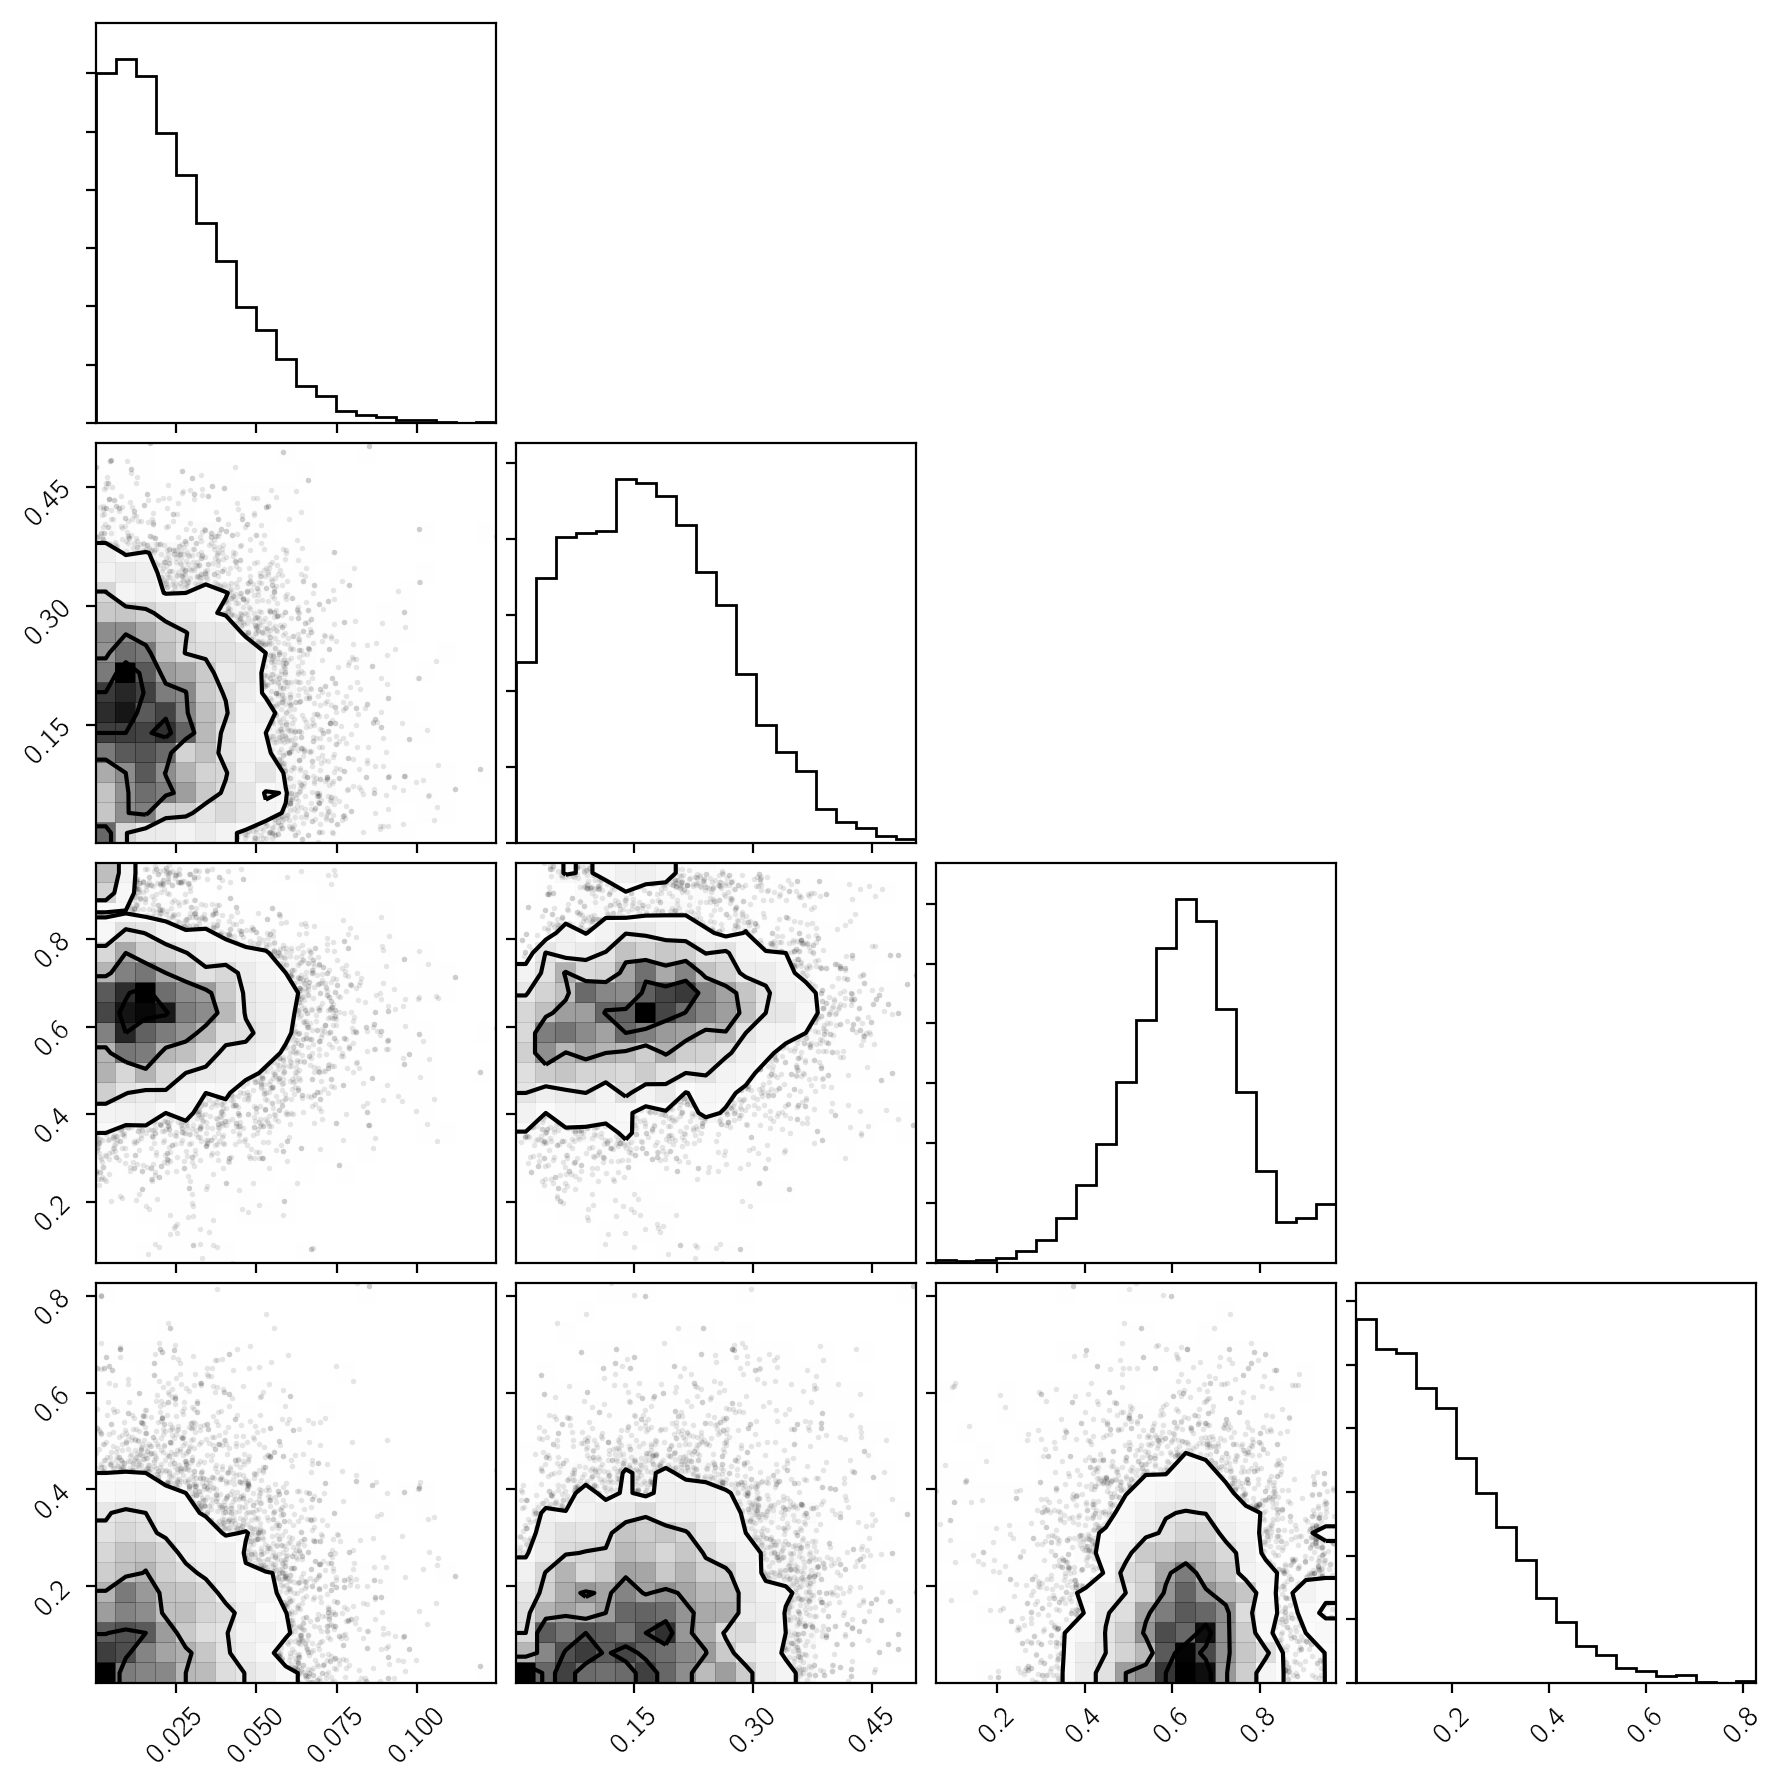

In [176]:
corner.corner(get_value_for_param(chain[:, 4*n_planets:5*n_planets], *e_range));

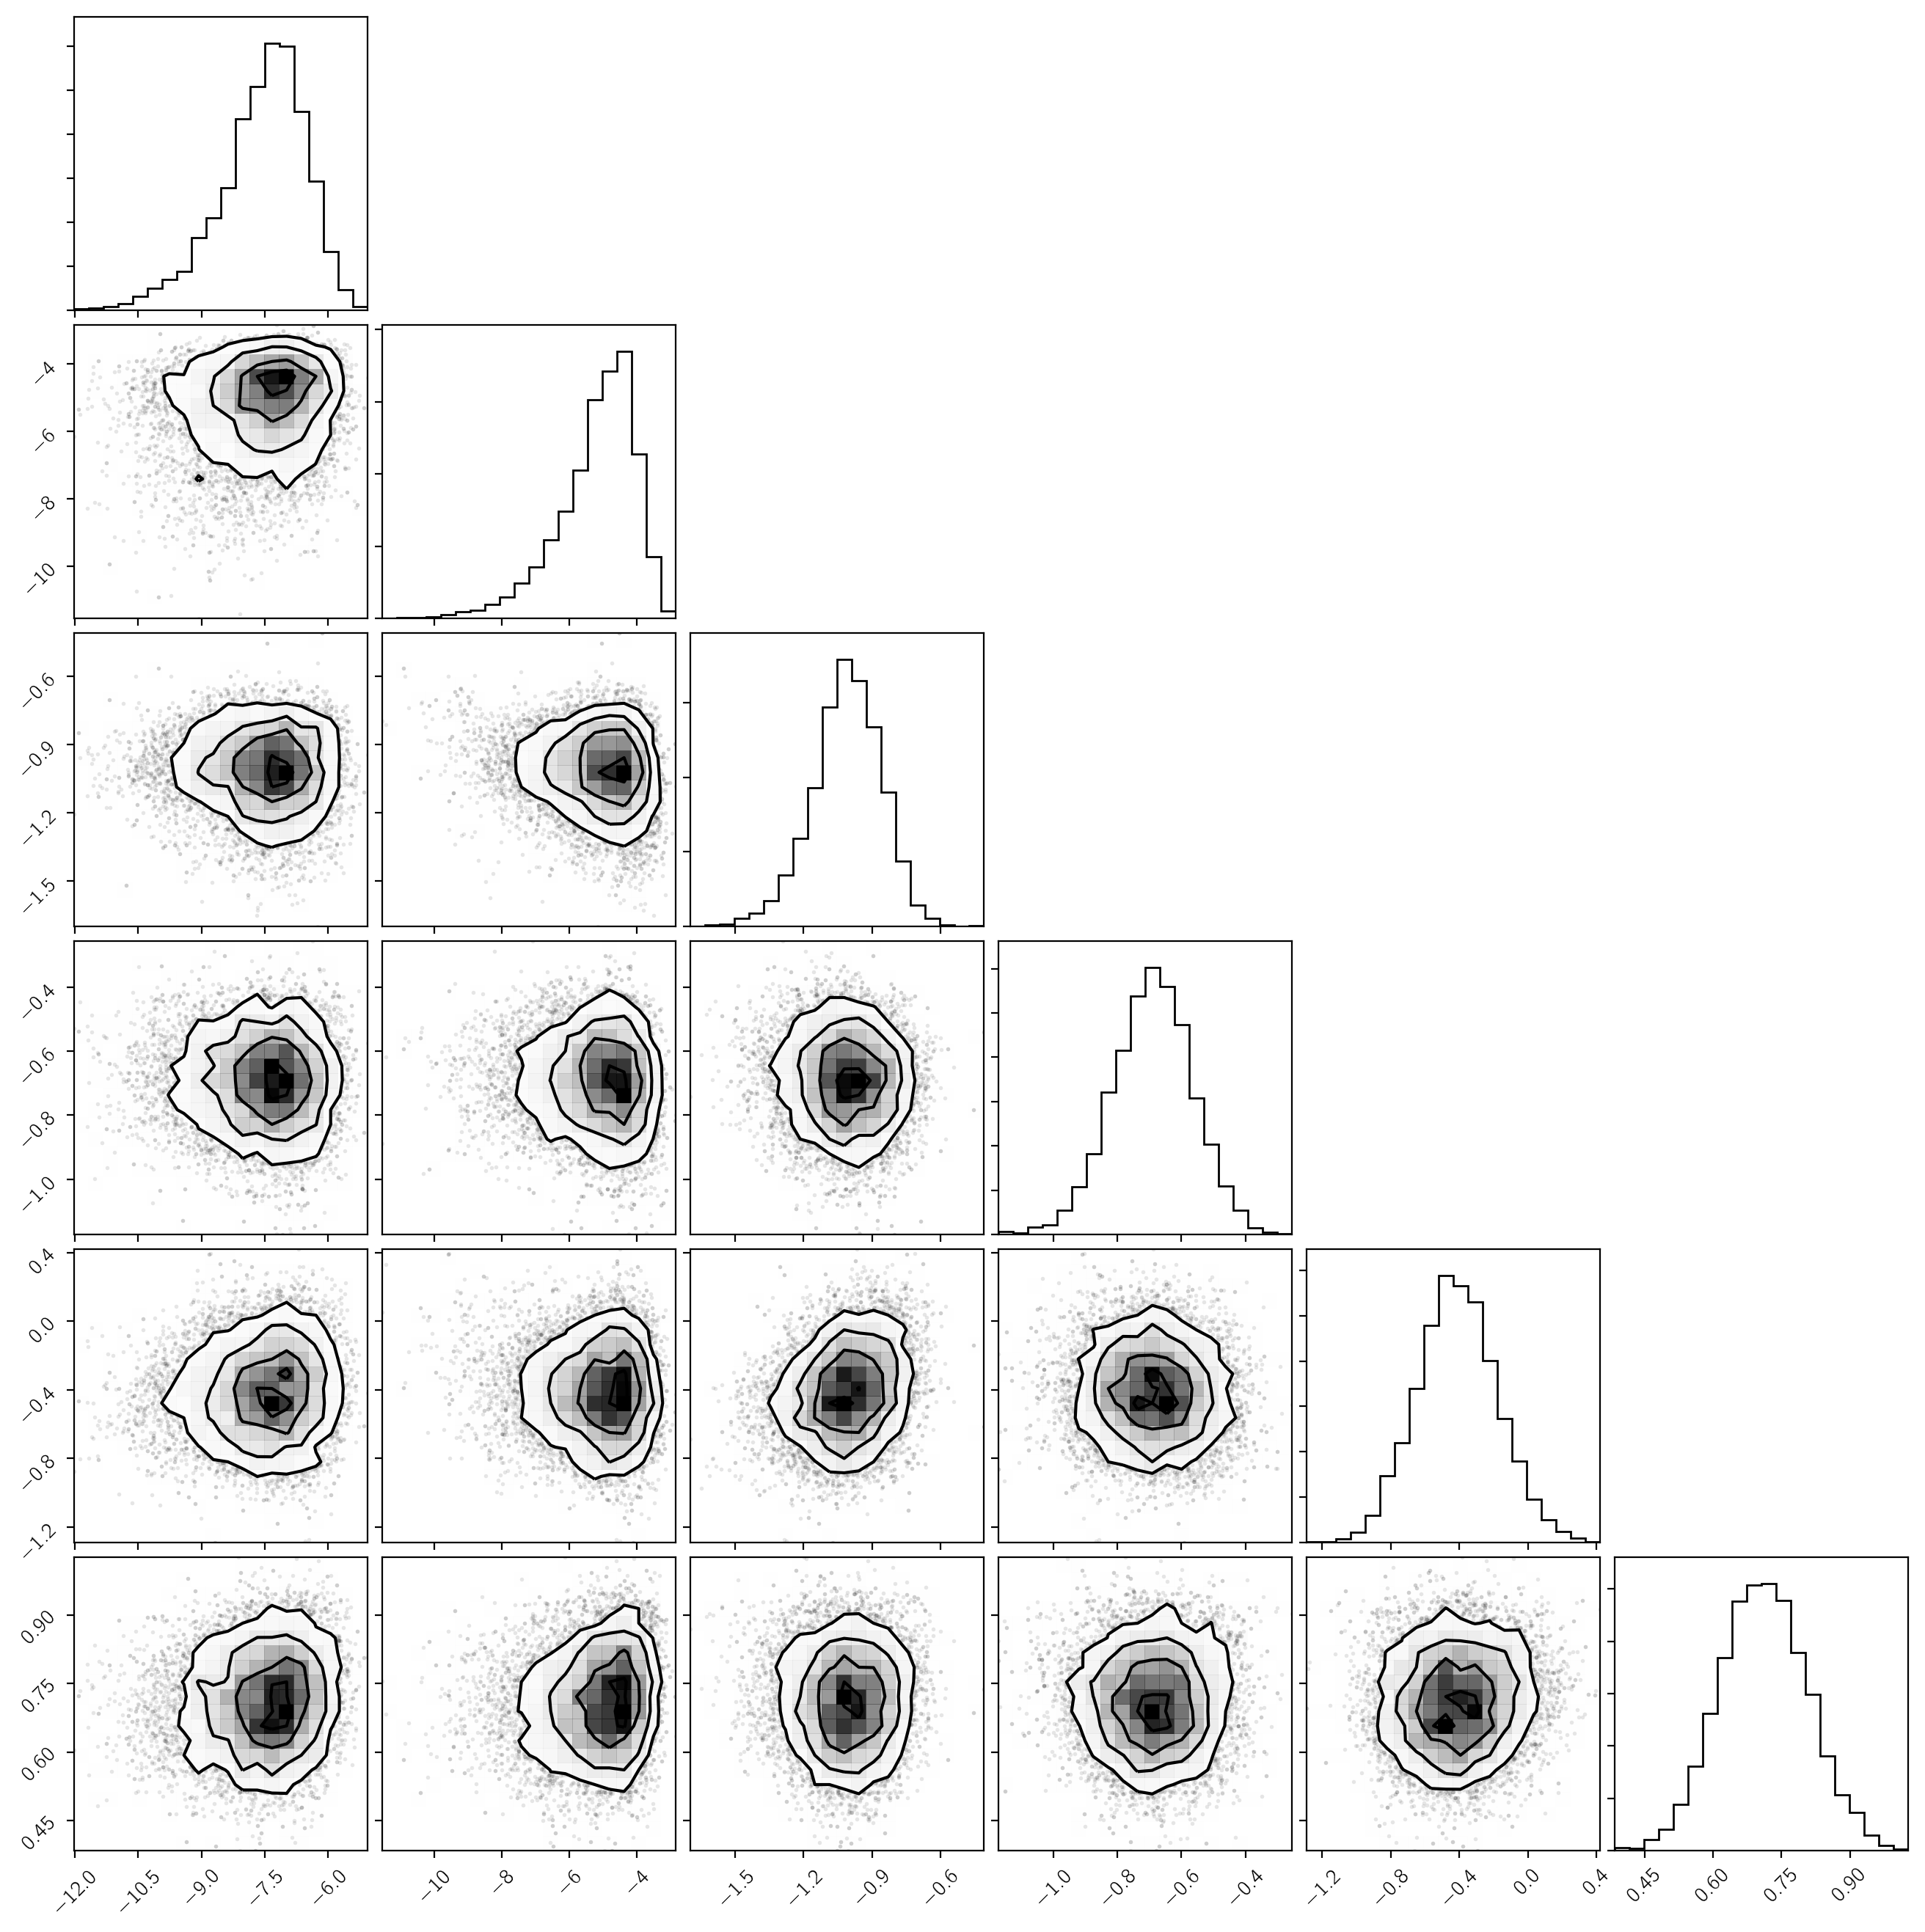

In [177]:
corner.corner(chain[:, 5*n_planets:7*n_planets]);

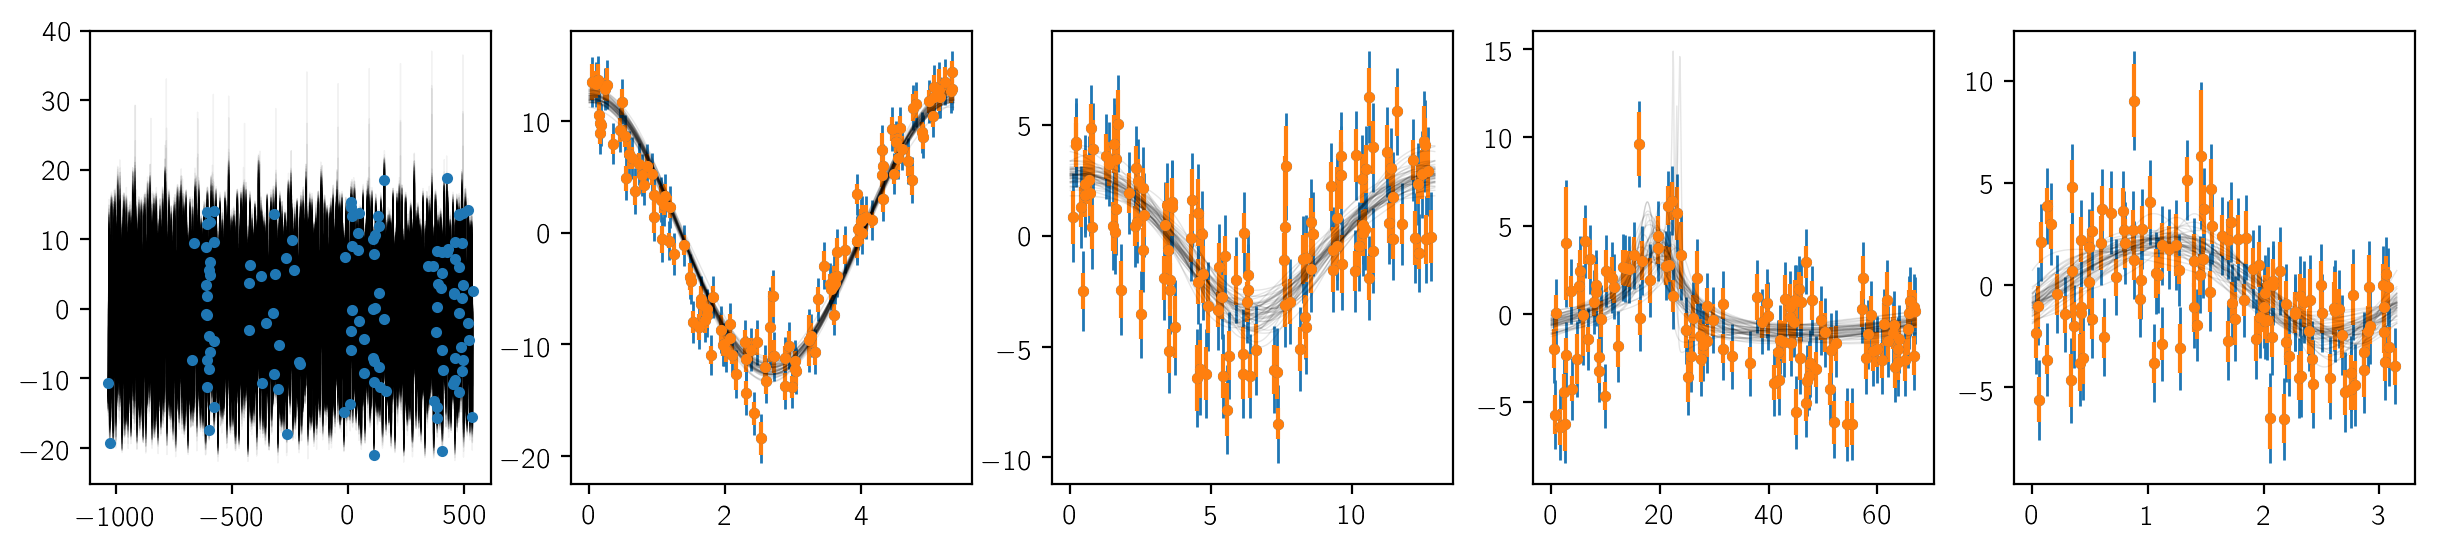

In [178]:
model = helpers.TFModel(log_prob, var_list, feed_dict=feed_dict)
model.setup(session)

best_sample = chain[np.argmax(lp_chain)]
best_feed_dict = model.vector_to_feed_dict(best_sample)

inds = np.random.randint(len(chain), size=100)
fig, axes = plt.subplots(1, 1 + n_planets, figsize=(15, 3))

ax = axes[0]
x = np.arange(t.min(), t.max(), 0.1)
for i in inds:
    sample = chain[i]
    fd = model.vector_to_feed_dict(sample)
    
    fd[t_tensor] = x
    m = session.run(rv_model, feed_dict=fd)
    ax.plot(x, m, "k", alpha=0.05, lw=0.5)
ax.plot(t, y, ".")

models, periods, err = session.run([rv_models, tf.exp(log_P), tf.sqrt(yerr2+jitter2)], feed_dict=best_feed_dict)
for n in range(n_planets):
    ax = axes[n+1]
    x = np.linspace(0, periods[n], 1000)
    for i in np.random.randint(len(chain), size=50):
        sample = chain[i]
        fd = model.vector_to_feed_dict(sample)
        t0_value = session.run(t0, feed_dict=fd)
        fd[t_tensor] = x
        m = session.run(rv_models, feed_dict=fd)
        ax.plot(x, m[:, n], "k", alpha=0.1, lw=0.5)

    mask = np.arange(n_planets) != n
    ax.errorbar(t%periods[n], y - np.sum(models[:, mask], axis=1), fmt=".", yerr=err, lw=1)
    ax.errorbar(t%periods[n], y - np.sum(models[:, mask], axis=1), fmt=".", yerr=yerr)

In [179]:
session.run(tf.sqrt(jitter2))

1.9552843872167454

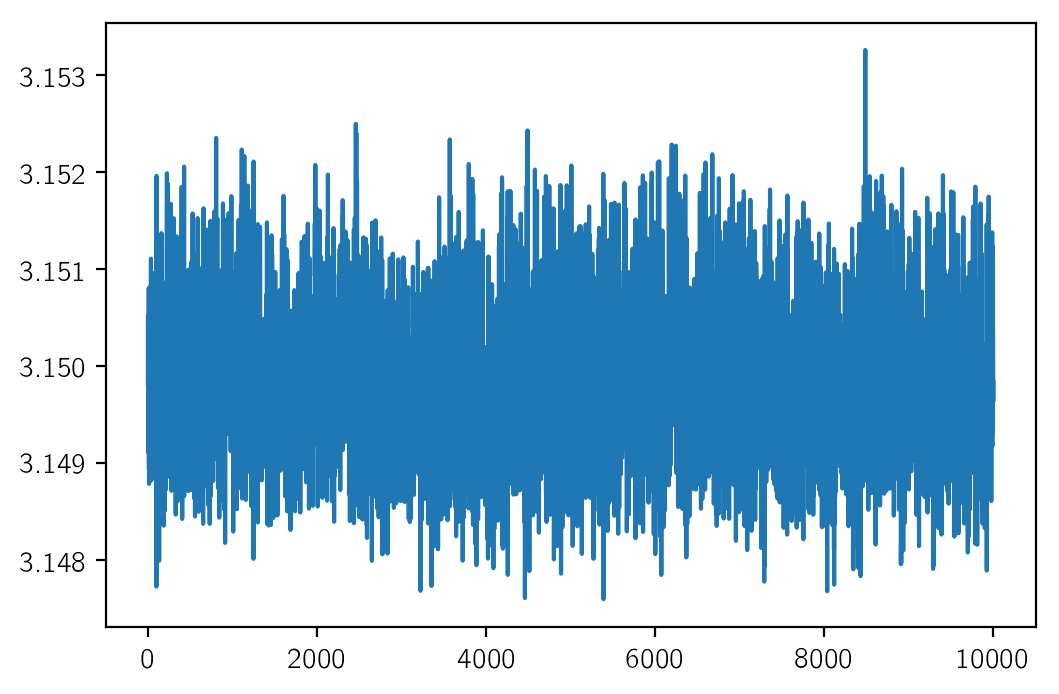

In [181]:
plt.plot(np.exp(get_value_for_param(chain[:, 7], *log_P_range)))

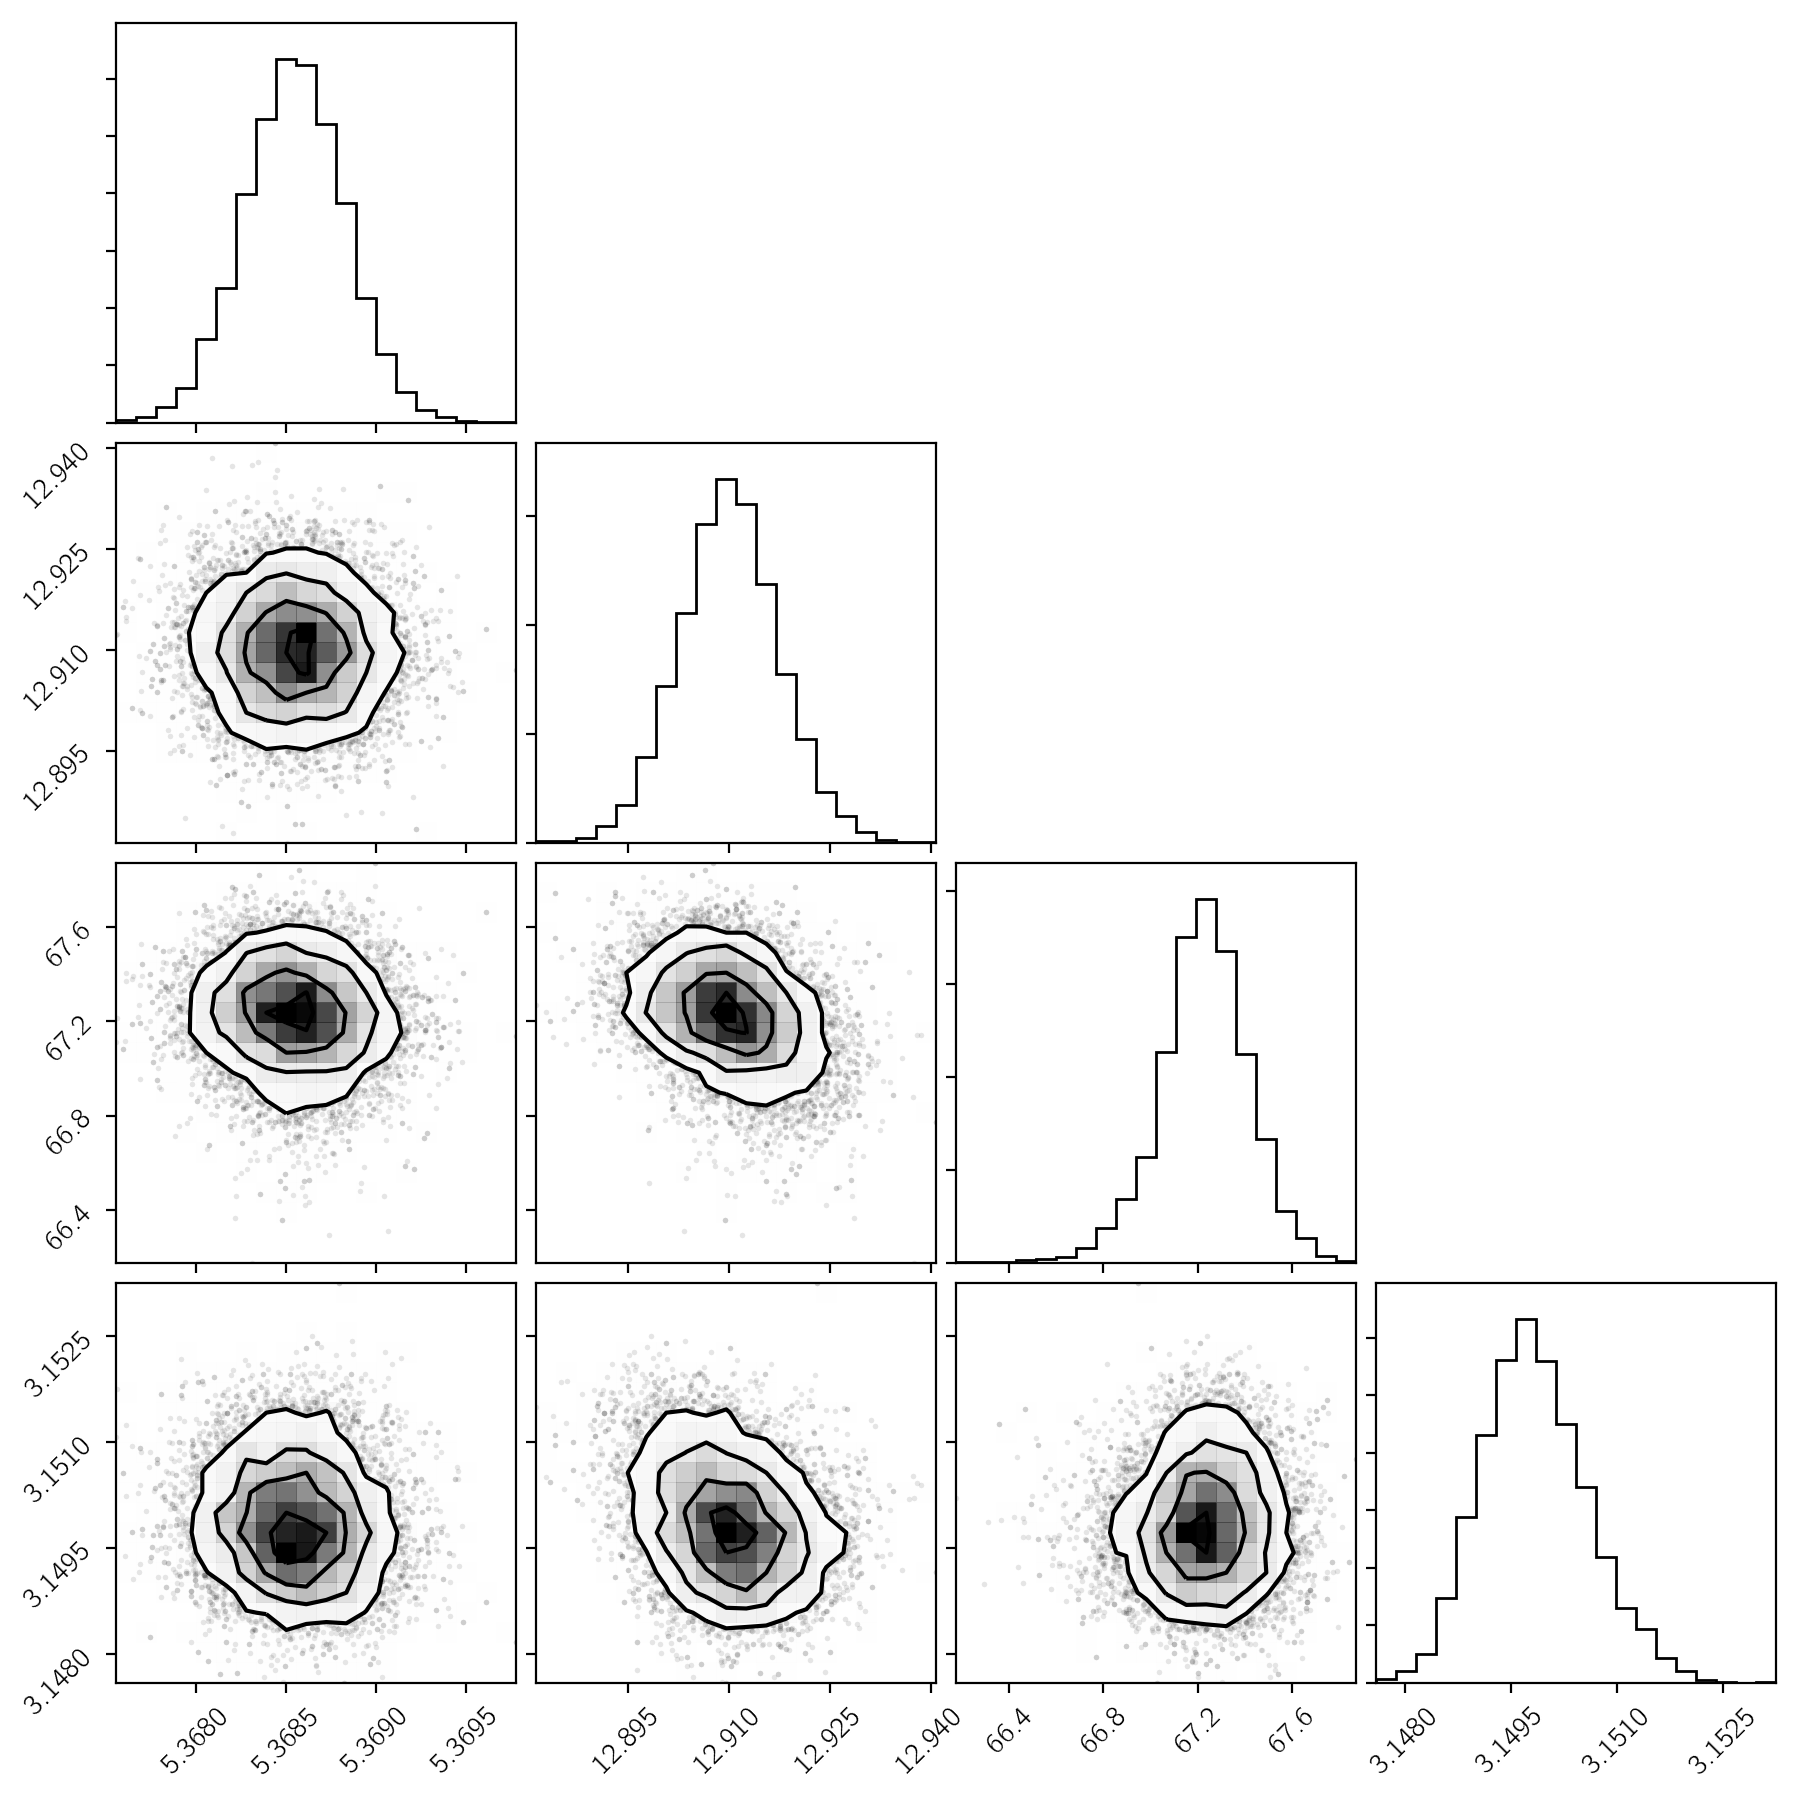

In [184]:
corner.corner(np.exp(get_value_for_param(chain[:, n_planets:2*n_planets], *log_P_range)));